# Carga y Limpieza de Datos

In [5]:
# Importo paquetes

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse

In [6]:
X_train = sparse.load_npz("./Data/X_train_BoW.npz")
X_test = sparse.load_npz("./Data/X_test_BoW.npz")
y_train = pd.read_csv("./Data/y_train.csv", header=None)
y_test = pd.read_csv("./Data/y_test.csv", header=None)

In [7]:
y_train = y_train[0]
y_test = y_test[0]

In [8]:
X_train

<1424931x34378 sparse matrix of type '<class 'numpy.int64'>'
	with 5064539 stored elements in Compressed Sparse Row format>

# Modelado

In [9]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, roc_curve, roc_auc_score, auc
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import scipy.stats as st
from sklearn.externals import joblib

## 1. Naive Bayes + Regresión Logística

In [10]:
models = [BernoulliNB(), LogisticRegression()]

In [11]:
params = [{},
          {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]

In [12]:
grids = []
i = 0
for i in range(len(models)):
    gs = GridSearchCV(models[i], params[i], scoring='roc_auc', verbose= 10, n_jobs=-1, cv=3)
    print (gs)
    fit = gs.fit(X_train, y_train)
    grids.append(fit)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:   55.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:  1.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:  2.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:  2.8min remaining:   28.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  3.1min finished
C:\Users\juan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\juan\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations."

In [13]:
y_probs = []
for i in grids:
    print ("Mejor Modelo: ",i.best_estimator_)
    print ("AUC: ",i.best_score_)
    y_pred = i.predict(X_test)
    print ("Matriz de Confusión:\n",confusion_matrix(y_test, y_pred))
    print ("Accuracy: ",accuracy_score(y_test, y_pred))
    print ("Recall: ",recall_score(y_test, y_pred))
    print ("Precision: ",precision_score(y_test, y_pred),"\n")
    y_aux = i.predict_proba(X_test)
    y_probs.append(y_aux[:,1])

Mejor Modelo:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
AUC:  0.8452680369837403
Matriz de Confusión:
 [[588078  13432]
 [ 15874   3989]]
Accuracy:  0.952836701948749
Recall:  0.20082565574183153
Precision:  0.22897652258768153 

Mejor Modelo:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
AUC:  0.8597821125237164
Matriz de Confusión:
 [[600344   1166]
 [ 18578   1285]]
Accuracy:  0.9682252045067938
Recall:  0.06469314806424005
Precision:  0.5242758057935537 



In [18]:
joblib.dump(grids[0], './Modelos/BoW/BoW_NB.sav')
joblib.dump(grids[1], './Modelos/BoW/BoW_LR.sav')

['./Modelos/BoW/BoW_LR.sav']

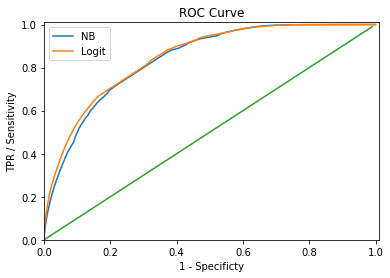

In [16]:
fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_probs[0])
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_probs[1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['NB','Logit'])
plt.show()

In [17]:
print('AUC-NB=', auc(fpr_nb, tpr_nb))
print('AUC-Logit=', auc(fpr_log, tpr_log))

AUC-NB= 0.8389243670726327
AUC-Logit= 0.8481723579608044


## 2. Random Forest + AdaBoost

In [29]:
models = [RandomForestClassifier(class_weight='balanced'),AdaBoostClassifier(base_estimator=DecisionTreeClassifier())]

In [30]:
params = [{'n_estimators': st.randint(50,200), 
           'max_features': st.randint(10,50), 
           'max_depth': st.randint(5,100), 
           'max_depth': st.randint(5,100)},
          {"base_estimator__max_depth": st.randint(10,50),
           "base_estimator__min_samples_split": st.randint(5,15),
           "base_estimator__min_samples_leaf": st.randint(5,15),
           "base_estimator__max_features": st.randint(20, 60),
           "n_estimators": st.randint(20,200),
           "learning_rate": st.uniform(0.01, 1)
          }]

In [31]:
grids = []
i = 0
for i in range(len(models)):
    gs = RandomizedSearchCV(models[i], params[i], n_iter = 10, scoring='roc_auc', verbose= 10, n_jobs=-1, cv=3, random_state=42)
    print (gs)
    fit = gs.fit(X_train, y_train)
    grids.append(fit)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DF26494898>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DF264949E8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DF26494E10>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc',

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 26.2min remaining: 15.2min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 29.4min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 32.2min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 32.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DF26494C50>, 'base_estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DF264A4208>, 'base_estimator__min_samples_leaf': <scipy.stats._distn_infra...A4668>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_fro

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 14.8min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 15.5min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 17.7min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.6min finished


In [32]:
y_probs = []
for i in grids:
    print ("Mejor Modelo: ",i.best_estimator_)
    print ("AUC: ",i.best_score_)
    y_pred = i.predict(X_test)
    print ("Matriz de Confusión:\n",confusion_matrix(y_test, y_pred))
    print ("Accuracy: ",accuracy_score(y_test, y_pred))
    print ("Recall: ",recall_score(y_test, y_pred))
    print ("Precision: ",precision_score(y_test, y_pred),"\n")
    y_aux = i.predict_proba(X_test)
    y_probs.append(y_aux[:,1])

Mejor Modelo:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=24,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=186, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
AUC:  0.8372086989915208
Matriz de Confusión:
 [[321565 279945]
 [  1803  18060]]
Accuracy:  0.5465718658519119
Recall:  0.9092282132608367
Precision:  0.06060301001661046 

Mejor Modelo:  AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=34,
            max_features=37, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random

In [33]:
joblib.dump(grids[0], './Modelos/BoW/BoW_RF.sav')
joblib.dump(grids[1], './Modelos/BoW/BoW_AB.sav')

['AB.sav']

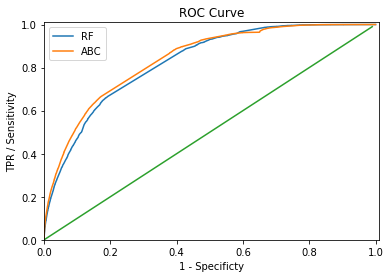

In [34]:
fpr_RF,tpr_RF,thr_RF = roc_curve(y_test, y_probs[0])
fpr_ABC,tpr_ABC,thr_ABC = roc_curve(y_test, y_probs[1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_RF,tpr_RF)
plt.plot(fpr_ABC,tpr_ABC)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['RF', 'ABC'])
plt.show()

In [35]:
print('AUC-RF=', auc(fpr_RF, tpr_RF))
print('AUC-ABC=', auc(fpr_ABC, tpr_ABC))

AUC-RF= 0.8250597705988236
AUC-ABC= 0.8378906607751083


## 3. XGBoost + LGBM

In [12]:
models = [XGBClassifier(nthreads=-1), lgb.LGBMClassifier()]

In [18]:
params = [{"n_estimators": st.randint(200,1000), # Number of boosted trees to fit.
            "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
            "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
            "colsample_bytree": st.beta(10, 1), #     Subsample ratio of columns when constructing each tree.
            "subsample": st.beta(10, 1),     # Subsample ratio of the training instance.
            "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
            'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
            "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
          },
         {"n_estimators": st.randint(200, 1000), # Number of boosted trees to fit.
            "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
            "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
            "colsample_bytree": st.beta(10, 1), #     Subsample ratio of columns when constructing each tree.
            "subsample": st.beta(10, 1),     # Subsample ratio of the training instance.
            "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
            'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
            "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
          }]

In [19]:
grids = []
i = 0
for i in range(len(models)):
    gs = RandomizedSearchCV(models[i], params[i], n_iter = 20, scoring='roc_auc', verbose= 10, n_jobs=-1, cv=3, random_state=42)
    print (gs)
    fit = gs.fit(X_train.astype('float32'), y_train.astype('float32'))
    grids.append(fit)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, nthreads=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022189952CF8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000221898F1E48>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000221898F1E80>, 'cols...98>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022189943B00>},
          pre_dispatch='2*n_jobs', random_st

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 53.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 76.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 105.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 144.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 184.6min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 203.3min remaining: 31.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 213.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022189943D68>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022189943C18>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022189943E80>, 'cols...F8>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002218994BF60>},
          pre_dispatc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 51.5min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 54.1min finished


In [20]:
y_probs = []
for i in grids:
    print ("Mejor Modelo: ",i.best_estimator_)
    print ("AUC: ",i.best_score_)
    y_pred = i.predict(X_test.astype('float32'))
    print ("Matriz de Confusión:\n",confusion_matrix(y_test.astype('float32'), y_pred.astype('float32')))
    print ("Accuracy: ",accuracy_score(y_test.astype('float32'), y_pred.astype('float32')))
    print ("Recall: ",recall_score(y_test.astype('float32'), y_pred.astype('float32')))
    print ("Precision: ",precision_score(y_test.astype('float32'), y_pred.astype('float32')),"\n")
    y_aux = i.predict_proba(X_test.astype('float32'))
    y_probs.append(y_aux[:,1])

Mejor Modelo:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7953193314112369, gamma=3.567533266935893,
       learning_rate=0.16237380387495232, max_delta_step=0, max_depth=11,
       min_child_weight=6.925470114081648, missing=None, n_estimators=264,
       n_jobs=1, nthread=None, nthreads=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0.2063640674119393, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9167590518620735)
AUC:  0.8184543859643412
Matriz de Confusión:
 [[601138    372]
 [ 19273    590]]
Accuracy:  0.9683845290992689
Recall:  0.029703468761012937
Precision:  0.6133056133056133 

Mejor Modelo:  LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7953193314112369, gamma=3.567533266935893,
        importance_type='split', learning_rate=0.16237380387495232,
        max_depth=11, min_child_samples=20,
        min_child_weight=6.925470114081648

In [21]:
joblib.dump(grids[0], './Modelos/BoW/BoW_XGB.sav')
joblib.dump(grids[1], './Modelos/BoW/BoW_LGBM.sav')

['./Modelos/BoW/BoW_LGBM.sav']

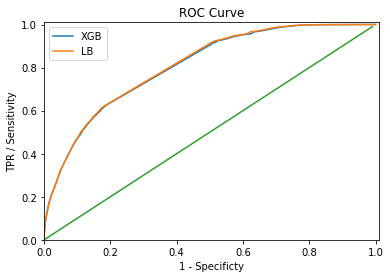

In [22]:
fpr_XGB,tpr_XGB,thr_XGB = roc_curve(y_test, y_probs[0])
fpr_LB,tpr_LB,thr_LB = roc_curve(y_test, y_probs[1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_XGB,tpr_XGB)
plt.plot(fpr_LB,tpr_LB)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['XGB', 'LB'])
plt.show()

In [23]:
print('AUC-XGB=', auc(fpr_XGB, tpr_XGB))
print('AUC-LB=', auc(fpr_LB, tpr_LB))

AUC-XGB= 0.8074733054069877
AUC-LB= 0.8103818783226622
